- Threshold policy: As we change threshold, look at p
- w-Lookahead policy: As we change w, look at p

We make some key changes to see if we can match Spencer et al. results.

- we generate all arrivals ahead of time to compare their queue lengths over time
- we set the fast service rate to 0 (jobs get deleted)
- instead of looking at the proportion of time that we are in surge, we look at the proportion of jobs that get kicked out 
- Spencer et al. uses p to denote 1-slow service rate so we use alpha instead of p for the proportion of jobs that get kicked out

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
lambd = 0.999
mu1 = 0.95
mu2 = 100 # doesn't matter in this case because fast gets kicked out immediately
c = 1
Tmax = 6000

p = 1 - mu1
surge_threshold = math.ceil(math.log(p / (1 - lambd), lambd / (1 - p)))
w = 6000 # lookahead is online in this case

In [3]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

# Define customer for the threshold policy
Customer = namedtuple("Customer", "arrival_time")
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

# Define customer for the w-lookahead policy
# mu1 is the slow service rate and mu2 is the fast service rate
WCustomer = namedtuple("WCustomer", "arrival_time slow_service_time fast_service_time enter_service_time service_time arrival_index fast")
def wcustomer(arrival_time=-1, mu1=-1, mu2=-1, arrival_index=0):
    slow = exp(mu1)
    fast = 0 #slow * mu1/mu2
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_slow_fast(arrival_time=-1, slow=2, fast=0, arrival_index=0):
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_with_parameters(w, current_time, fast):
    if fast:
        return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                         fast_service_time=w.fast_service_time, enter_service_time=current_time,
                         service_time=current_time+w.fast_service_time,
                         arrival_index=w.arrival_index, fast=True)
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                     fast_service_time=w.fast_service_time, enter_service_time=current_time,
                     service_time=current_time+w.slow_service_time,
                     arrival_index=w.arrival_index, fast=False)

def wcustomer_deleted(w):
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=0,
                     fast_service_time=w.fast_service_time, enter_service_time=w.enter_service_time,
                     service_time=w.service_time,
                     arrival_index=w.arrival_index, fast=True)

In [4]:
def gen_arrivals(lambd, mu1, mu2, Tmax): 
    # generate arrivals independent of whether or not we speed up the customers
    T_advance = [0]  # list of events that get generated in advance
    arrivals = []
    while T_advance[-1] < Tmax:
        t_temp = T_advance[-1]
        next_arrival = t_temp + 1
        T_advance.append(next_arrival)
        arrivals.append(wcustomer(next_arrival, mu1, mu2, len(T_advance) - 2))
    return arrivals

In [5]:
def gen_deterministic_arrivals(lambd, mu1, mu2, Tmax): 
    # generate arrivals independent of whether or not we speed up the customers
    T_advance = [0]  # list of events that get generated in advance
    arrivals = []
    arrivals.append(wcustomer_slow_fast(0, 2, 0, 0))
    arrivals.append(wcustomer_slow_fast(1, 1, 0, 1))
    arrivals.append(wcustomer_slow_fast(4, 3, 0, 2))
    arrivals.append(wcustomer_slow_fast(5, 1, 0, 3))
    arrivals.append(wcustomer_slow_fast(6, 10, 0, 4))
    arrivals.append(wcustomer_slow_fast(9, 10, 0, 5))
    return arrivals

In [6]:
def gen_deletion_list(T, N):
    deletions = list()
    current_min = N[-1]
    for i in range(len(N) - 2, 0, -1):
        if N[i] < current_min:
            current_min = N[i]
            deletions.append(i + 1)
    return deletions

In [7]:
def execute_deletions(T, N):
    deletions = gen_deletion_list(T, N)
    #print(deletions)
    for i in deletions:
        for j in range(i, len(N)):
            N[j] -= 1
    return T, N, len(deletions) / len(N)

In [8]:
# Implement no policy (always use slow service time) on an array of arrivals.
# Returns T, N, waiting times. Proportion of surge is always 0.
def MM1Normal(arrivals, c, Tmax):
    T             = [0]  # list of times that events occur in real time
    N             = [0]  # initial state of the system
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1] + 1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                servers.append(wcustomer_with_parameters(arrival, T[-1], False))
            else:
                queue.append(arrival)
                
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times

In [9]:
# Implement the threshold policy on an array of arrivals.
# Returns T, N, waiting times, proportion of surge
def MM1WithOneThreshold(arrivals, surge_threshold, c, Tmax):
    T               = [0]  # list of times that events occur
    N               = [0]  # initial state of the system
    use_surge_num   = 0
    use_surge_denom = 0
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if next_arrival < next_departure:
            N.append(N[-1] + 1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                if N[-1] >= surge_threshold:
                    servers.append(wcustomer_with_parameters(arrival, T[-1], True))
                    if T[-1] > 0:
                        use_surge_num += 1
                else:
                    servers.append(wcustomer_with_parameters(arrival, T[-1], False)) 
                if T[-1] > 0:
                    use_surge_denom += 1
            else:
                queue.append(arrival)
            
        ##### DEPARTURE #####     
        else:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                if N[-1] >= surge_threshold:
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], True))
                    if T[-1] > 0:
                        use_surge_num += 1
                else:
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False)) 
                if T[-1] > 0:
                    use_surge_denom += 1
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, use_surge_num / use_surge_denom

In [10]:
# Implement the w-lookahead policy on an array of arrivals.
# Returns T, N, waiting times, proportion of surge
def MM1WithWLookaheadConstant(arrivals, c, w, Tmax):
    T               = [0]  # list of times that events occur in real time
    N               = [0]  # initial state of the system
    use_surge_num   = 0
    use_surge_denom = 0
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 1
                num_departures = 0
                arrival_lookahead_index = arrival_index
                service_lookahead_index = arrival.arrival_index
                use_slow = False
                while arrival_lookahead_index < arrivals_len and service_lookahead_index < arrivals_len:
                    w_arrival = arrivals[arrival_lookahead_index].arrival_time
                    w_departure = cumulative_service_time + arrivals[service_lookahead_index].slow_service_time
                    #print("arrival lookahead index %d, next arrival %.2f" % (arrival_lookahead_index, w_arrival))
                    #print("next departure %.2f" % (w_departure))
                    if w_arrival <= w_departure and w_arrival <= min(w_lookahead, Tmax):
                        num_arrivals += 1
                        arrival_lookahead_index += 1
                    elif w_departure <= min(w_lookahead, Tmax):
                        cumulative_service_time = w_departure
                        num_departures += 1      
                        service_lookahead_index += 1
                    else:
                        break
                        
                    if num_departures >= num_arrivals \
                        and num_departures > 0: # use the slow service rate 
                        use_slow = True
                        break
                        
                if use_slow:
                    servers.append(wcustomer_with_parameters(arrival, T[-1], False))
                    print("Look ahead from %d at time %.3f has Departures %d Arrivals %d -> use SLOW 1" % (N[-1], T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(arrival, T[-1], True))
                    #arrivals[arrival.arrival_index] = wcustomer_deleted(arrivals[arrival.arrival_index])
                    if T[-1] > 1000:
                        use_surge_num += 1
                    print("Look ahead from %d at time %.3f has Departures %d Arrivals %d -> use FAST 1" % (N[-1], T[-1], num_departures, num_arrivals))
                if T[-1] > 1000:
                    use_surge_denom += 1
            else:
                queue.append(arrival)
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        else:
            N.append(N[-1]-1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
                
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                arrival_lookahead_index = arrival_index
                service_lookahead_index = next_to_enter.arrival_index
                use_slow = False
                while arrival_lookahead_index < arrivals_len and service_lookahead_index < arrivals_len:
                    w_arrival = arrivals[arrival_lookahead_index].arrival_time
                    w_departure = cumulative_service_time + arrivals[service_lookahead_index].slow_service_time
                    #print("arrival lookahead index %d, next arrival %.2f" % (arrival_lookahead_index, w_arrival))
                    #print("next departure %.2f" % (w_departure))
                        
                    if w_arrival <= w_departure and w_arrival <= min(w_lookahead, Tmax):
                        num_arrivals += 1
                        arrival_lookahead_index += 1
                        w_arrival = arrivals[arrival_lookahead_index].arrival_time
                    elif w_departure <= min(w_lookahead, Tmax):
                        cumulative_service_time = w_departure
                        num_departures += 1      
                        service_lookahead_index += 1
                    else:
                        break
                        
                    if num_departures >= num_arrivals \
                        and num_departures > 0: # use the slow service rate 
                        use_slow = True
                        break
                        
                if use_slow:
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
                    print("Look ahead from %d at time %.3f has Departures %d Arrivals %d -> use SLOW 2" % (N[-1], T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], True))
                    #arrivals[next_to_enter.arrival_index] = wcustomer_deleted(arrivals[next_to_enter.arrival_index])
                    if T[-1] > 1000:
                        use_surge_num += 1
                    print("Look ahead from %d at time %.3f has Departures %d Arrivals %d -> use FAST 2" % (N[-1], T[-1], num_departures, num_arrivals))
                if T[-1] > 1000:
                    use_surge_denom += 1
        
        if arrival_index < arrivals_len:
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, use_surge_num / use_surge_denom

# Graphs and Results

In [11]:
# Start and end proportions for graphing
start_prop = 0 #0.055
end_prop = 1.2 #0.058

In [18]:
arrivals = gen_arrivals(lambd, mu1, mu2, Tmax)

No Job Left Behind Surge Proportion 0.02


Text(0.5,1,'Number of clients in the M/M/C queue 1.00/0.95/1, with no policy')

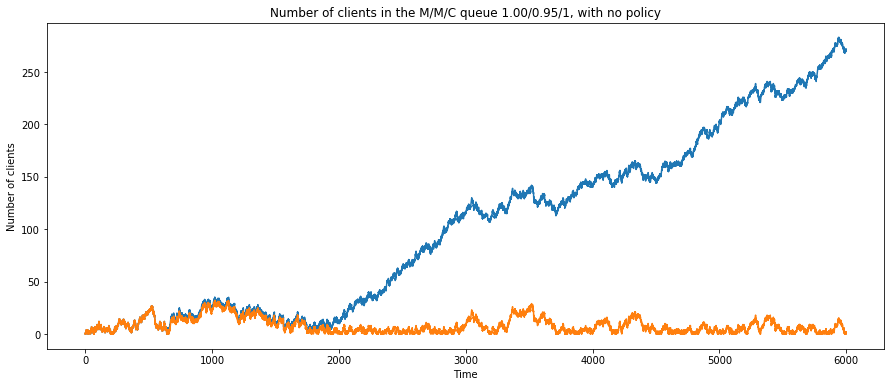

In [20]:
T1, N1, _ = MM1Normal(arrivals, c, Tmax)
T4, N4, surge_prop = execute_deletions(T1, N1.copy())
print("No Job Left Behind Surge Proportion %.2f" % (surge_prop))
start_index1 = int(len(T1)*start_prop)
end_index1 = int(len(T1)*end_prop)
figure(figsize=(15,6))
plot(T1[start_index1:end_index1], N1[start_index1:end_index1])
plot(T4[start_index1:end_index1], N4[start_index1:end_index1])
#scatter(T1[start_index1:end_index1], N1[start_index1:end_index1])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with no policy' % (lambd, mu1, c))

In [21]:
'''T3, N3, _, use_surge = MM1WithWLookaheadConstant(arrivals, c, w, Tmax)

start_index3 = int(len(T3)*start_prop)
end_index3 = int(len(T3)*end_prop)
figure(figsize=(15,6))
#scatter(T3[start_index:end_index], N3[start_index:end_index])
plot(T3[start_index3:end_index3], N3[start_index3:end_index3])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with w-lookahead online'
      % (lambd, mu1, c))
print("Use surge %.2f" % (use_surge))'''

'T3, N3, _, use_surge = MM1WithWLookaheadConstant(arrivals, c, w, Tmax)\n\nstart_index3 = int(len(T3)*start_prop)\nend_index3 = int(len(T3)*end_prop)\nfigure(figsize=(15,6))\n#scatter(T3[start_index:end_index], N3[start_index:end_index])\nplot(T3[start_index3:end_index3], N3[start_index3:end_index3])\nxlabel(\'Time\')\nylabel(\'Number of clients\')\ntitle(\'Number of clients in the M/M/C queue %.2f/%.2f/%d, with w-lookahead online\'\n      % (lambd, mu1, c))\nprint("Use surge %.2f" % (use_surge))'

Use surge 0.03


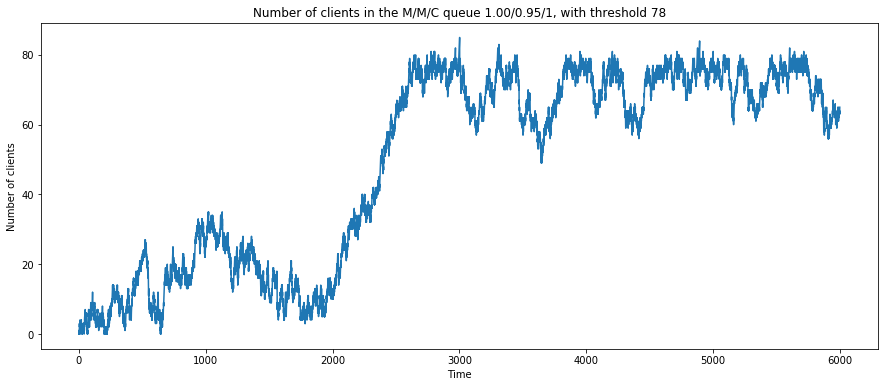

In [22]:
T2, N2, _, use_surge = MM1WithOneThreshold(arrivals, surge_threshold, c, Tmax)

start_index2 = int(len(T2)*start_prop)
end_index2 = int(len(T2)*end_prop)
figure(figsize=(15,6))
plot(T2[start_index2:end_index2], N2[start_index2:end_index2])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with threshold %d'
      % (lambd, mu1, c, surge_threshold))
print("Use surge %.2f" % (use_surge))

Text(0.5,1,'Number of clients in the M/M/C queue 1.00/0.95/1, with different heuristics')

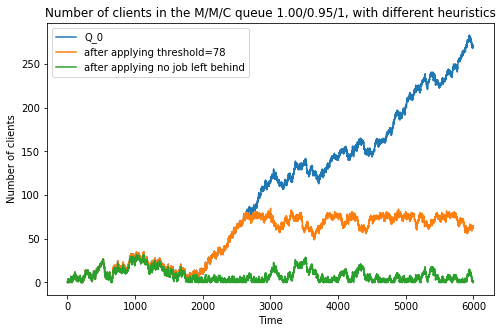

In [26]:
figure(figsize=(8,5))
plot(T1[start_index1:end_index1], N1[start_index1:end_index1], label="Q_0")
plot(T2[start_index2:end_index2], N2[start_index2:end_index2], label="after applying threshold=78")
#plot(T3[start_index3:end_index3], N3[start_index3:end_index3], label="after applying no job left behind")
plot(T4[start_index1:end_index1], N4[start_index1:end_index1], label="after applying no job left behind")
xlabel('Time')
ylabel('Number of clients')
legend()
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with different heuristics'
      % (lambd, mu1, c))

In [17]:
'''##### SURGE count and proportion #####
            if T[-1] >= 1000 and T[-1] <= 9000:
                if in_surge == 0 and S == 0: # first time, mark t_temp
                    start_measuring_surge = T[-2]
                t_delta = T[-1] - popped_customer.enter_service_time
                S = S + (t_delta * N[-2])
                if popped_customer.fast:
                    in_surge = in_surge + t_delta
            if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]'''

'##### SURGE count and proportion #####\n            if T[-1] >= 1000 and T[-1] <= 9000:\n                if in_surge == 0 and S == 0: # first time, mark t_temp\n                    start_measuring_surge = T[-2]\n                t_delta = T[-1] - popped_customer.enter_service_time\n                S = S + (t_delta * N[-2])\n                if popped_customer.fast:\n                    in_surge = in_surge + t_delta\n            if T[-1] > 9000:\n                if end_measuring_surge == 0:\n                    end_measuring_surge = T[-1]'